In [29]:
import os
import json
import numpy as np
import regex as re
import matplotlib.pyplot as plt

class MetricsPlotter:
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.metrics_data = [] 
        self.top_10_precision = {}
        self.top_10_recall = {}
        self.top_10_f1 = {}

    def read_json(self, file_path):
        with open(file_path, 'r') as file:
            return json.load(file)
            
    def sanitize_filename(self, filename):
        filename = filename.replace(' ', '_')
        filename = re.sub(r'[^\w\-_\.]', '', filename)
        return filename
        
    def get_params_string(self, params):
        summary = params.get('summary', {})
        ranking = params.get('ranking', {})
        entity = params.get('entity', {})
        relation = params.get('relation', {})

        preprocess_str = f"Preprocess: {params.get('preprocess', None)}" if params.get('preprocess', None) is not None else ''
        summary_method = f"Summary Method: {summary.get('summary_method', None)}" if summary.get('summary_method', None) is not None else ''
        summary_percentage = f"Summary Percentage: {summary.get('summary_percentage', None)}" if summary.get('summary_percentage', None) is not None else ''
        ranking_method = f"Ranking Method: {ranking.get('ranking', None)}" if ranking.get('ranking', None) is not None else ''
        ranking_perc_threshold = f"Ranking Perc Threshold: {ranking.get('ranking_perc_threshold', None)}" if ranking.get('ranking_perc_threshold', None) is not None else ''
        options_ent = f"Options Ent: {', '.join(sorted(entity.get('options_ent', [None])))}" if sorted(entity.get('options_ent', [None])) != [None] else ''
        options_rel = f"Options Rel: {', '.join(sorted(relation.get('options_rel', [None])))}" if sorted(relation.get('options_rel', [None])) != [None] else ''
        local_rm = f"Local RM: {relation.get('local_rm', None)}" if relation.get('local_rm', None) is not None else ''
        rebel_model = f"Rebel Model: {relation.get('rebel_model', None)}" if relation.get('rebel_model', None) is not None else ''
        
        params_list = [preprocess_str, summary_method, summary_percentage, ranking_method, ranking_perc_threshold, options_ent, options_rel, local_rm, rebel_model]
        params_str = '\n'.join(filter(None, params_list))

        return params_str

    def compute_average_rouge_scores(self, json_data):
        rouge_precision_scores = []
        rouge_recall_scores = []
        rouge_f1_scores = []
        for v in json_data.values():
            if 'rouge-2' in v:
                rouge_scores = v['rouge-2']
                if 'precision' in rouge_scores and 'recall' in rouge_scores and 'f1' in rouge_scores:
                    rouge_precision_scores.append(rouge_scores['precision'])
                    rouge_recall_scores.append(rouge_scores['recall'])
                    rouge_f1_scores.append(rouge_scores['f1'])
                else:
                    print("Warning: Missing Rouge scores in JSON data.")
            else:
                print("Warning: Missing Rouge scores in JSON data.")
        avg_precision = np.mean(rouge_precision_scores)
        avg_recall = np.mean(rouge_recall_scores)
        avg_f1 = np.mean(rouge_f1_scores)
        return avg_precision, avg_recall, avg_f1
        
    def print_metrics(self, json_file, params_str):
        with open(json_file) as f:
            data = json.load(f)
        avg_precision, avg_recall, avg_f1 = self.compute_average_rouge_scores(data)
        self.metrics_data.append({
            "Params": params_str,
            "Avg Rouge Precision": avg_precision,
            "Avg Rouge Recall": avg_recall,
            "Avg Rouge F1": avg_f1
        })
        # Debugging statement to check the structure
        print(f"Appended metrics: {self.metrics_data[-1]}")

    def plot_metrics_bar_directory(self):
        for root, dirs, _ in os.walk(self.root_dir):
            for dir_name in dirs:
                metrics_path = os.path.join(root, dir_name, 'metrics.json')
                params_path = os.path.join(root, dir_name, 'params.json')
    
                if all(os.path.exists(p) for p in [metrics_path, params_path]):
                    try:
                        params = self.read_json(params_path)
                        params_str = self.get_params_string(params)
                        self.print_metrics(metrics_path, params_str)  # Uncommented this line
                    except Exception as e:
                        print(f"Error processing files in directory: {os.path.join(root, dir_name)}")
                        print(e) 

    def print_metrics_data(self):
            for params, metrics in self.metrics_data.items():
                print(f"Params: {params}")
                print(f"Metrics: {metrics}")

    def sort_and_store_top_metrics(self):
        sorted_by_precision = sorted(self.metrics_data, key=lambda x: x["Avg Rouge Precision"], reverse=True)[:10]
        print(f"Top 10 by Precision: {sorted_by_precision}")
        sorted_by_recall = sorted(self.metrics_data, key=lambda x: x["Avg Rouge Recall"], reverse=True)[:10]
        print(f"Top 10 by Recall: {sorted_by_recall}")
        sorted_by_f1 = sorted(self.metrics_data, key=lambda x: x["Avg Rouge F1"], reverse=True)[:10]
        print(f"Top 10 by F1: {sorted_by_f1}")

        self.top_10_precision = {item["Params"]: item["Avg Rouge Precision"] for item in sorted_by_precision}
        self.top_10_recall = {item["Params"]: item["Avg Rouge Recall"] for item in sorted_by_recall}
        self.top_10_f1 = {item["Params"]: item["Avg Rouge F1"] for item in sorted_by_f1}

    def print_top_metrics(self):
        print("Top 10 Avg Rouge Precision:")
        for params, value in self.top_10_precision.items():
            print(f"Params: {params}\nPrecision: {value}\n")
        
        print("Top 10 Avg Rouge Recall:")
        for params, value in self.top_10_recall.items():
            print(f"Params: {params}\nRecall: {value}\n")
        
        print("Top 10 Avg Rouge F1:")
        for params, value in self.top_10_f1.items():
            print(f"Params: {params}\nF1: {value}\n")

    def plot_top_metrics(self):
        fig_dir = 'plot/plot_metrics/rouge/top_10_rouge'
        if not os.path.exists(fig_dir):
            os.makedirs(fig_dir)
        def plot_metric(metric_dict, title, ylabel):
            params = list(metric_dict.keys())
            values = list(metric_dict.values())
            plt.figure(figsize=(25, 10))
            plt.bar(params, values, color='skyblue')
            plt.xlabel(ylabel)
            plt.ylabel("Score")
            plt.title(title)
            plt.grid(axis='y', linestyle='--', alpha=0.4)
            plt.xticks(rotation=45, ha='right')  # Adjust rotation angle and alignment
            plt.tight_layout()
            fig_path = os.path.join(fig_dir, f"{title}_plot.png")
            plt.savefig(fig_path)
            plt.show()
            plt.close()


        plot_metric(self.top_10_f1, "Top 10 Avg Rouge F1 Scores", "F1 Score")
        plot_metric(self.top_10_precision, "Top 10 Avg Rouge Precision Scores", "Precision Score")
        plot_metric(self.top_10_recall, "Top 10 Avg Rouge Recall Scores", "Recall Score")

In [30]:
root_directory = "/Users/martina/Desktop/concept_map/experiments"
plotter = MetricsPlotter(root_directory)
plotter.plot_metrics_bar_directory()
plotter.sort_and_store_top_metrics()
plotter.print_top_metrics()

Appended metrics: {'Params': "Preprocess: {'preprocess': True, 'spacy_model': 'en_core_web_lg'}\nSummary Method: lex-rank\nSummary Percentage: 30\nRanking Method: page_rank\nRanking Perc Threshold: 0.15\nOptions Rel: rebel\nLocal RM: True\nRebel Model: ./src/fine_tune_rebel/finetuned_rebel.pth", 'Avg Rouge Precision': 6.265011352262093, 'Avg Rouge Recall': 13.134597904271043, 'Avg Rouge F1': 7.961482649364628}
Appended metrics: {'Params': "Preprocess: {'preprocess': True, 'spacy_model': 'en_core_web_lg'}\nSummary Method: lex-rank\nSummary Percentage: 15\nOptions Rel: rebel\nLocal RM: True\nRebel Model: ./src/fine_tune_rebel/finetuned_rebel.pth", 'Avg Rouge Precision': 3.7108513784999584, 'Avg Rouge Recall': 18.88687152011284, 'Avg Rouge F1': 5.820415375139413}
Appended metrics: {'Params': "Preprocess: {'preprocess': True, 'spacy_model': 'en_core_web_lg'}\nSummary Method: lex-rank\nSummary Percentage: 15\nRanking Method: page_rank\nRanking Perc Threshold: 0.3\nOptions Rel: rebel\nLocal 

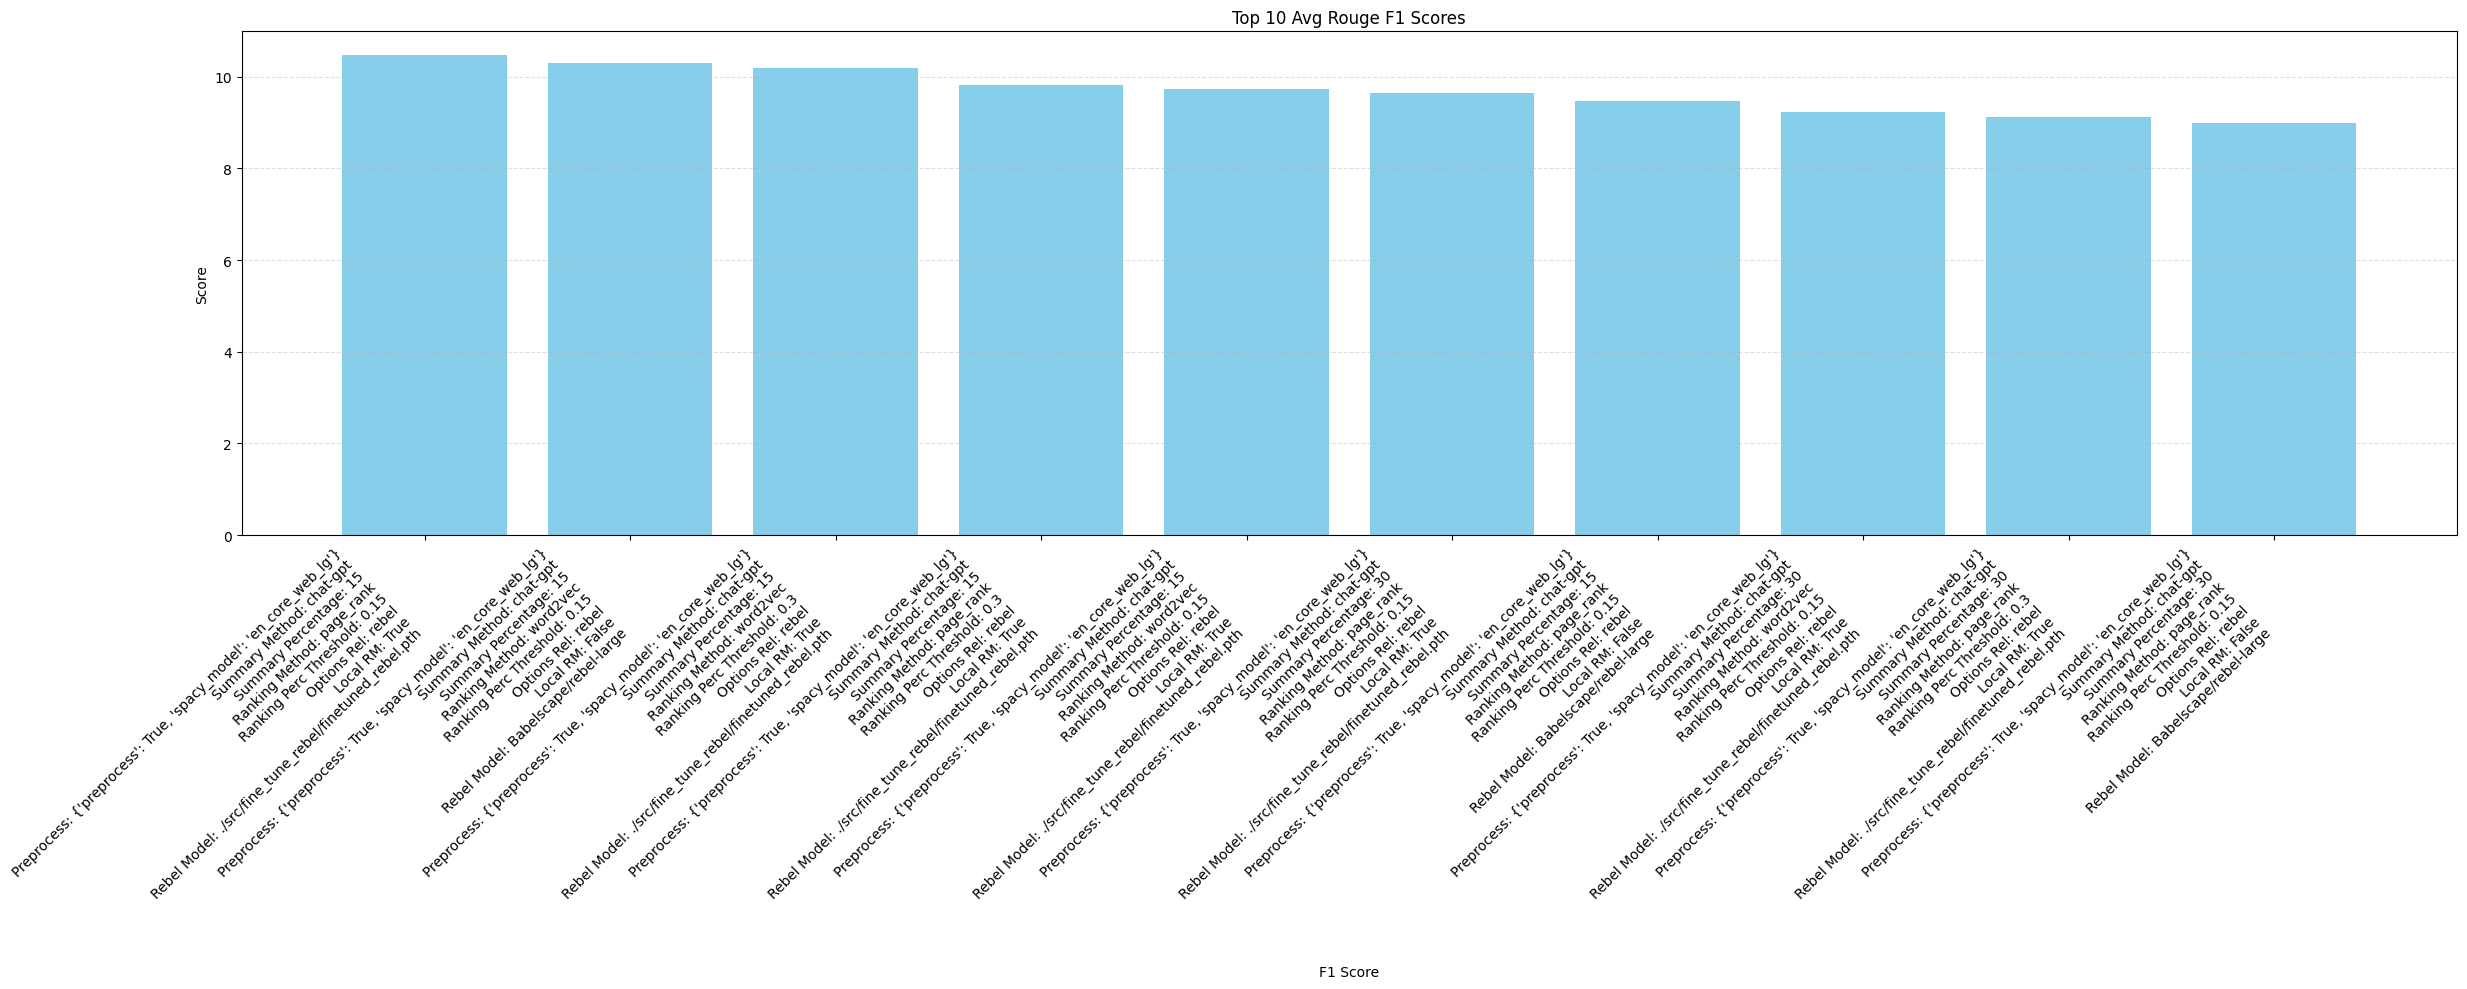

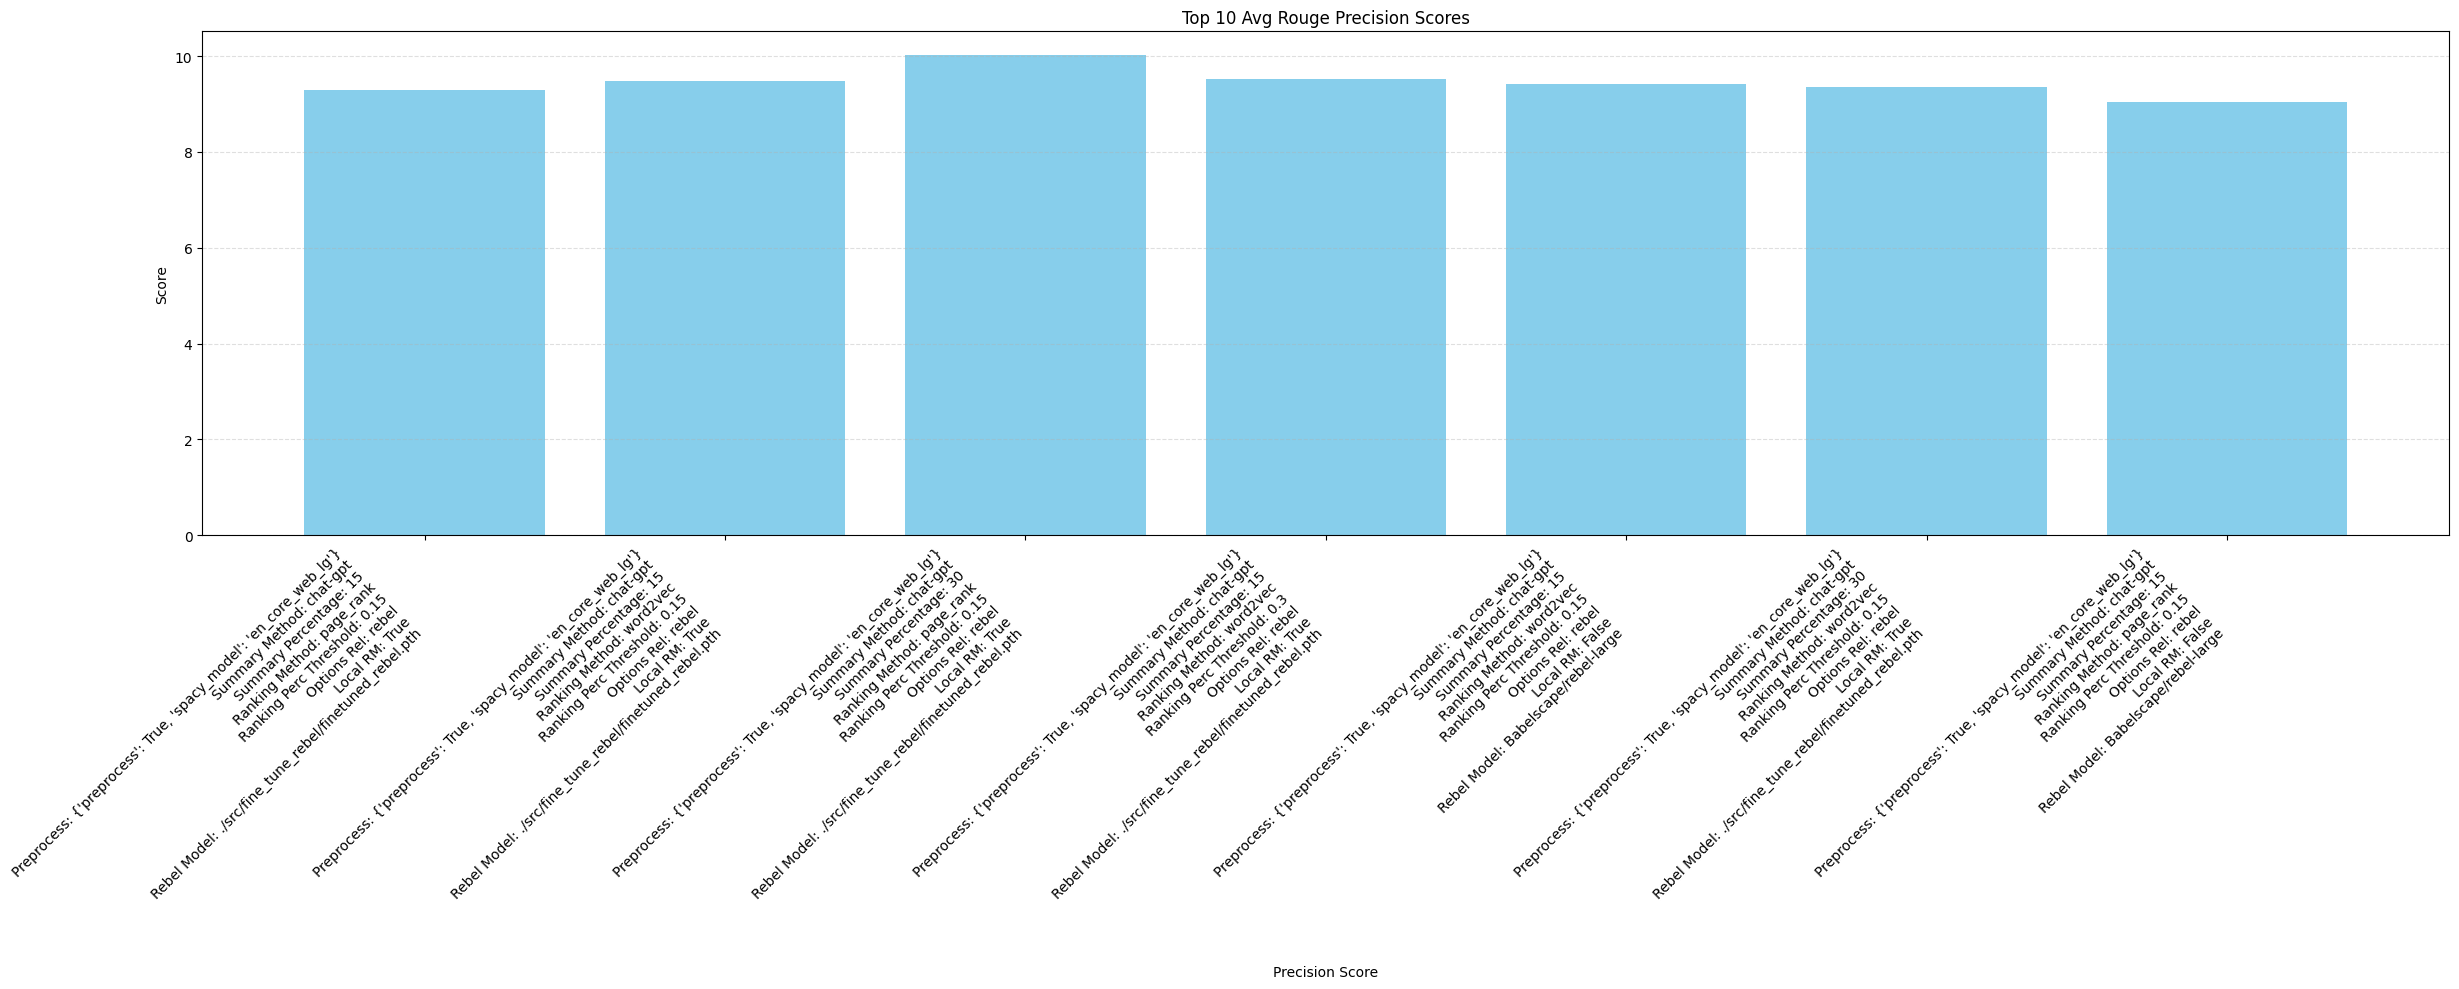

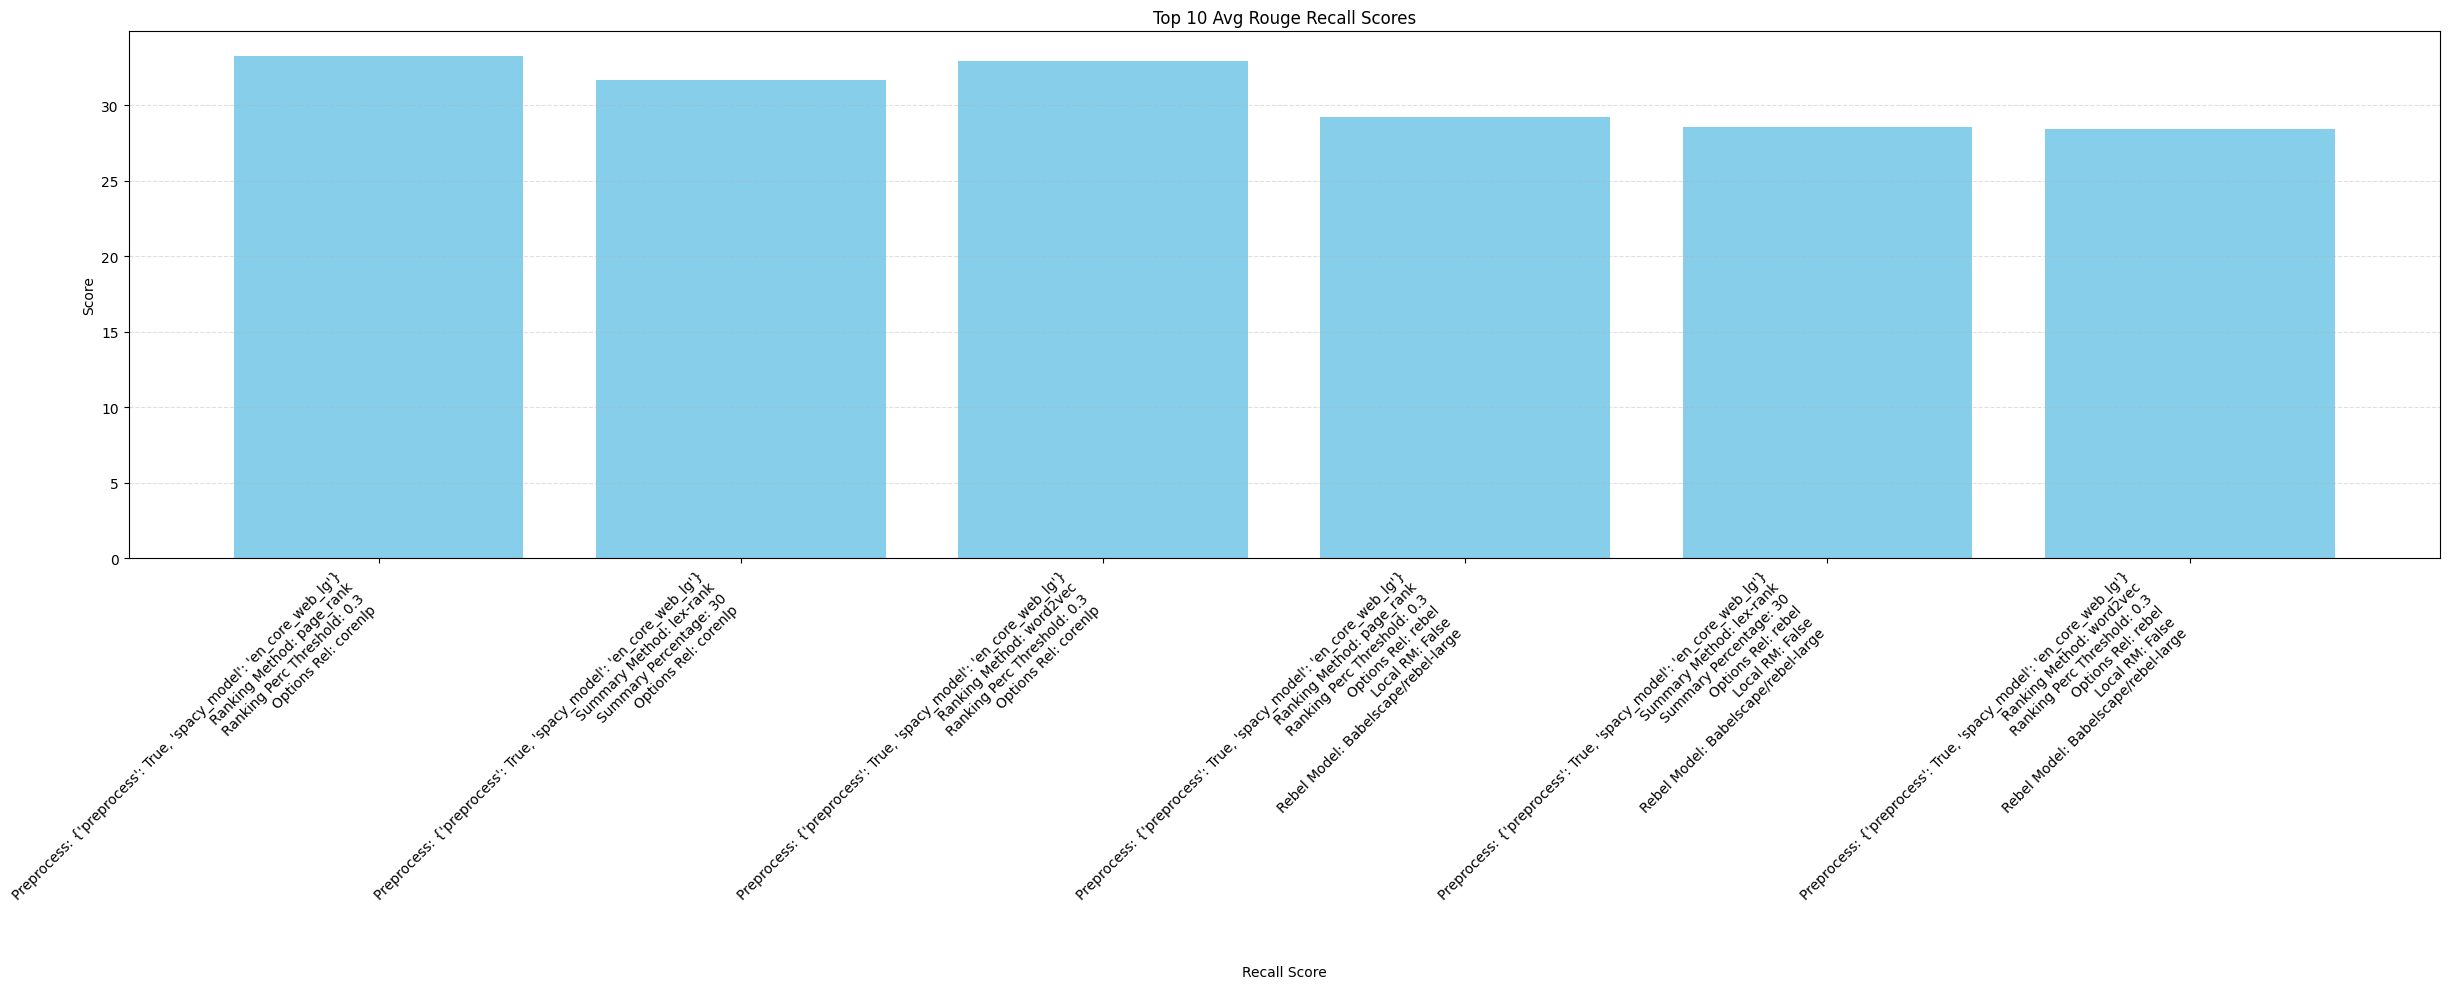

In [31]:
plotter.plot_top_metrics()